# Adjustable Forecasting

The purpose is to check, by adjusting the params in each moving window, would performance get better.

* Logged moving average time series
* Moving window solution
* Holt Winters
* Adjust the params after adding the previous test data into the training data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
import itertools
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings("ignore")

In [2]:
sample_train_df1 = pd.read_pickle('sample_train_df1.pkl')
sample_test_df1 = pd.read_pickle('sample_test_df1.pkl')
print(sample_train_df1.shape, sample_test_df1.shape)

sample_train_df2 = pd.read_pickle('sample_train_df2.pkl')
sample_test_df2 = pd.read_pickle('sample_test_df2.pkl')
print(sample_train_df2.shape, sample_test_df2.shape)

sample_train_df1.head()

(100, 2) (14, 2)
(100, 2) (10, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


In [3]:
train1_col = sample_train_df1['client_count']
train2_col = sample_train_df2['client_count']
test1_col = sample_test_df1['client_count']
test2_col = sample_test_df2['client_count']

# Generate logged moving average for both time series sequences
ts_log_train1 = np.log(train1_col)
ts_moving_avg_train1 = ts_log_train1.rolling(window=4,center=False).mean().dropna()
ts_log_test1 = np.log(test1_col)
ts_moving_avg_test1 = ts_log_test1.rolling(window=4,center=False).mean().dropna()

ts_log_train2 = np.log(train2_col)
ts_moving_avg_train2 = ts_log_train2.rolling(window=4,center=False).mean().dropna()
ts_log_test2 = np.log(test2_col)
ts_moving_avg_test2 = ts_log_test2.rolling(window=4,center=False).mean().dropna()

print(ts_moving_avg_train1.shape, ts_moving_avg_train2.shape, ts_moving_avg_test1.shape, ts_moving_avg_test2.shape)
ts_moving_avg_test1.head()

(97,) (97,) (11,) (7,)


purchase_date
2019-05-25    3.748604
2019-05-26    3.671921
2019-05-27    3.625118
2019-05-28    3.512122
2019-05-29    3.391662
Name: client_count, dtype: float64

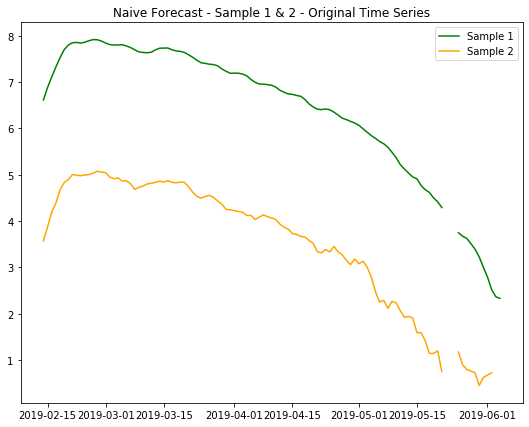

In [4]:
plt.figure(figsize=(9,7))
plt.plot(ts_moving_avg_train1.index, ts_moving_avg_train1, label='Sample 1', color='green')
plt.plot(ts_moving_avg_test1.index, ts_moving_avg_test1, color='green')
plt.plot(ts_moving_avg_train2.index, ts_moving_avg_train2, label='Sample 2', color='orange')
plt.plot(ts_moving_avg_test2.index, ts_moving_avg_test2, color='orange')
plt.legend(loc='best')
plt.title("Naive Forecast - Sample 1 & 2 - Original Time Series")
plt.show()

In [7]:
def geterate_train_test_sequences(all_ts, forecast_ts, train_period, test_period):
    """
    It divide a whole time series into multiple train-test sequences.
    
    @param all_ts: The whole time series. Its index is the date.
    @param forecast_ts: The final testing data.
    @param train_period: The number of days in the training data.
    @param test_period: The number of days in the testing data.
    @return: A dictionary where stores the index and each (train, test) pair.
    """
    seq_idx = 0
    train_test_dct = {}
    
    train_idx = 0
    
    while train_idx <= len(all_ts)-train_period-test_period:
        train_seq = all_ts[train_idx:train_idx+train_period]
        test_seq = all_ts[train_idx+train_period:train_idx+train_period+test_period]
        
        train_test_dct[seq_idx] = {'train': train_seq, 'test': test_seq}
        
        train_idx += test_period
        seq_idx += 1
        
    train_seq = all_ts[train_idx:]
    train_test_dct[seq_idx] = {'train': train_seq, 'test': forecast_ts}
        
    return train_test_dct

In [8]:
ts_ma1_train_test_dct = geterate_train_test_sequences(ts_moving_avg_train1, ts_moving_avg_test1, train_period=14, test_period=7)
ts_ma2_train_test_dct = geterate_train_test_sequences(ts_moving_avg_train2, ts_moving_avg_test2, train_period=14, test_period=7)

In [ ]:
title = "Holt Winters"
rmse_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_log1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=6, trend='add',
                                 seasonal='mul', damped=False).fit(smoothing_level = 0.8,smoothing_slope = 0.6)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))

plt.title(title + " - Sample 1 - Logged Time Series - Moving Window")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

In [28]:
# I'm using grid search here...
params = {
    'seasonal_periods': range(6,8),
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'smoothing_level': [0.2, 0.6, 0.8],
    'smoothing_slope': [0.4, 0.6, 0.7]
}

grid_params = list(itertools.product(params['seasonal_periods'], params['trend'], 
                       params['seasonal'], params['smoothing_level'], params['smoothing_slope']))
print(len(grid_params))
print(grid_params[7:9])

72
[(6, 'add', 'add', 0.8, 0.6), (6, 'add', 'add', 0.8, 0.7)]


In [29]:
def grid_search_dotdotdot(initial_rmse, train, test):
    best_params = None
    
    for params in grid_params:
        try:
            model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=params[0], trend=params[1],
                                     seasonal=params[2], damped=False).fit(smoothing_level = params[3],smoothing_slope = params[4])
            y_pred = model_fit.forecast(len(test))
            
            rmse = sqrt(mean_squared_error(test, y_pred))
            if rmse < initial_rmse:
                best_params = params
        except:
            continue
            
    return best_params

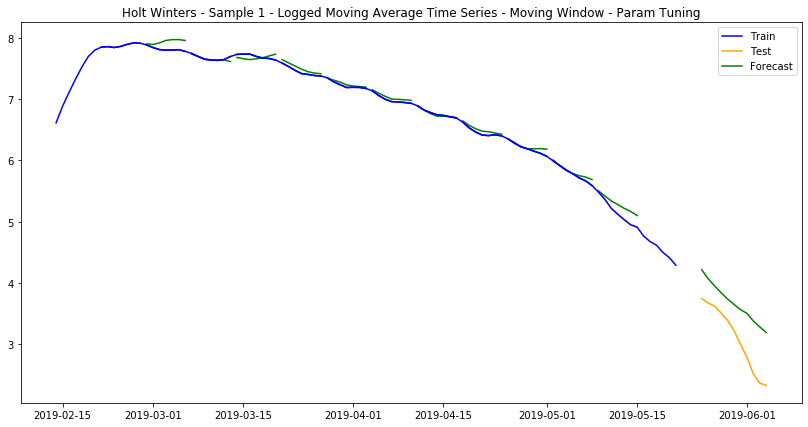

[0.1348, 0.0314, 0.0646, 0.0561, 0.0282, 0.0414, 0.0116, 0.0453, 0.0552, 0.0456, 0.1516, 0.6079]
historical average rmse 0.0605


In [32]:
title = "Holt Winters"
rmse_lst = []
best_params_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma1_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    if len(best_params_lst) > 0:
        params = best_params_lst[-1]
        model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=params[0], trend=params[1],
                                     seasonal=params[2], damped=False).fit(smoothing_level = params[3],smoothing_slope = params[4])
    else:
        model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=6, trend='add',
                                 seasonal='mul', damped=False).fit(smoothing_level = 0.8,smoothing_slope = 0.6)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))
    
    best_params = grid_search_dotdotdot(rmse, train, test)
    if best_params is not None:
        best_params_lst.append(best_params)

plt.title(title + " - Sample 1 - Logged Moving Average Time Series - Moving Window - Param Tuning")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

In [33]:
best_params_lst

[(7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'mul', 0.8, 0.6),
 (7, 'add', 'mul', 0.8, 0.6),
 (7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'mul', 0.8, 0.6),
 (7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'add', 0.8, 0.7),
 (7, 'mul', 'mul', 0.8, 0.4),
 (7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'add', 0.8, 0.7),
 (7, 'mul', 'mul', 0.8, 0.7)]

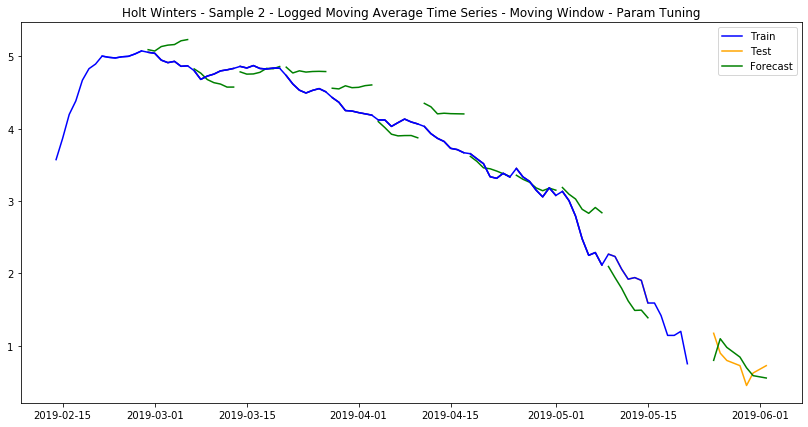

[0.2411, 0.161, 0.0654, 0.2377, 0.3209, 0.1607, 0.4261, 0.0635, 0.0583, 0.4603, 0.3147, 0.213]
historical average rmse 0.2282


In [34]:
title = "Holt Winters"
rmse_lst = []
best_params_lst = []
all_y_pred = None
plt.figure(figsize=(14,7))

for idx, train_test_pair in ts_ma2_train_test_dct.items():
    train = train_test_pair['train']
    test = train_test_pair['test']
    
    if len(best_params_lst) > 0:
        params = best_params_lst[-1]
        model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=params[0], trend=params[1],
                                     seasonal=params[2], damped=False).fit(smoothing_level = params[3],smoothing_slope = params[4])
    else:
        model_fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=6, trend='add',
                                 seasonal='mul', damped=False).fit(smoothing_level = 0.8,smoothing_slope = 0.6)
    y_pred = model_fit.forecast(len(test))
    
    plt.plot(train.index, train, label='Train', color='blue')
    plt.plot(test.index, test, label='Test', color='orange')
    plt.plot(test.index, y_pred, label='Forecast', color='green')
    if idx == 0:
        plt.legend(loc='best')

    rmse = sqrt(mean_squared_error(test, y_pred))
    rmse_lst.append(round(rmse, 4))
    
    best_params = grid_search_dotdotdot(rmse, train, test)
    if best_params is not None:
        best_params_lst.append(best_params)

plt.title(title + " - Sample 2 - Logged Moving Average Time Series - Moving Window - Param Tuning")
plt.show()
print(rmse_lst)
print('historical average rmse', round(np.mean(rmse_lst[0:-1]), 4))

In [35]:
best_params_lst

[(7, 'mul', 'mul', 0.6, 0.6),
 (7, 'mul', 'mul', 0.8, 0.4),
 (7, 'mul', 'mul', 0.8, 0.6),
 (7, 'mul', 'mul', 0.6, 0.7),
 (7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'mul', 0.6, 0.7),
 (7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'mul', 0.8, 0.6),
 (7, 'mul', 'mul', 0.8, 0.4),
 (7, 'mul', 'mul', 0.8, 0.7),
 (7, 'mul', 'mul', 0.6, 0.7),
 (7, 'mul', 'mul', 0.2, 0.4)]

## Summary

It's more promising that I expected!

* First of all, in each moving window, there was 72 iterations, but the whole process was fast, much faster than I thought.
* For sample 1, it didn't work better than the solution without param tuning for forecasting data, but in the past moving windows, it did bring down the average rmse.
* For sample 2, it's more promising, both historical avg rmse and forecasting dropped, forecasting rmse dropped a lot.